In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CTDAPD Dataset.csv")
# ======================================================
# ⚙️ Step 4: Preprocessing + Label encoding + SMOTE
# ======================================================
X = df.drop(columns=["Label"])
y = df["Label"]

# Label Encoding for categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# Handle missing values: Replace None/NaN values with mean (for numerical columns)
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
X.fillna(X.mean(numeric_only=True), inplace=True)  # Impute numerical columns with the mean

# Handle missing values for categorical columns
for col in categorical_cols:
    X[col].fillna(X[col].mode()[0], inplace=True)  # Impute categorical columns with the mode (most frequent value)

# Label Encoding for target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=["Label"])], axis=1)
print("\nBalanced shape:", df_balanced.shape)
print("\nBalanced Label distribution:\n", df_balanced["Label"].value_counts())

/tmp/ipython-input-9-3052242267.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mode()[0], inplace=True)  # Impute categorical columns with the mode (most frequent value)
/tmp/ipython-input-9-3052242267.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.




Balanced shape: (93178, 30)

Balanced Label distribution:
 Label
1    46589
0    46589
Name: count, dtype: int64


In [ ]:
# Total missing values
df_balanced.isnull().sum()

,0
Date,0
Source_IP,0
Destination_IP,0
Source_Port,0
Destination_Port,0
Protocol_Type,0
Flow_Duration,0
Packet_Size,0
Flow_Bytes_per_s,0
Flow_Packets_per_s,0


In [ ]:
from google.colab import files

# Save the DataFrame to a CSV file
df_balanced.to_csv("CTDAPD_Balanced_Dataset.csv", index=False)

# Download it to your local machine
files.download("CTDAPD_Balanced_Dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target from the balanced DataFrame
X = df_balanced.drop(columns=["Label"])
y = df_balanced["Label"]

# Stratified train-test split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check the class distribution
print("Train set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())

Train set class distribution:
 Label
1    37271
0    37271
Name: count, dtype: int64
Test set class distribution:
 Label
1    9318
0    9318
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
X_train_scaled[:5]

array([[ 0.49018925,  0.7292501 ,  0.8978479 ,  1.2774522 , -0.23223641,
        -0.00970712, -1.01841372, -1.11532353,  0.58766543,  0.66011729,
         0.03533463, -1.35324352,  0.35687271, -0.96242357, -1.01222303,
         2.48157907, -0.51891046, -1.04818684,  1.24007882, -0.23741253,
         0.5412023 ,  1.59508002,  0.37662071,  0.28116524,  0.81307122,
        -0.2665165 ,  0.5996339 ,  1.53574869, -0.04577534],
       [ 1.20441643,  0.7292501 , -0.58886552,  0.43352097,  2.96301437,
        -1.94443514, -0.00375916, -1.00708513, -0.95264295, -0.38935545,
         0.27473783,  0.32071799,  0.75239649, -0.07664039,  0.56402957,
        -0.32449074,  0.97051707,  0.99862452, -0.91956035,  0.08433633,
         0.5412023 , -0.1568569 , -1.58907465, -2.23487547, -0.6324365 ,
        -0.48846458, -1.66768425, -0.31859253,  0.36993907],
       [ 0.38194038,  0.7292501 , -0.58886552,  1.2448655 , -0.28035135,
        -1.94443514, -0.59119075,  2.01637409, -0.67571263,  1.57996366,
  

Select All Feature

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k='all')
selector.fit(X_train_scaled, y_train)


SelectKBest(k='all')

Applying ML Models


Logistic Regression - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.6833, Std = 0.0043
Train Accuracy: 0.6840
Log Loss: 0.5994
ROC AUC: 0.7438
              precision    recall  f1-score   support

           0       0.68      0.69      0.69      9318
           1       0.69      0.67      0.68      9318

    accuracy                           0.68     18636
   macro avg       0.68      0.68      0.68     18636
weighted avg       0.68      0.68      0.68     18636



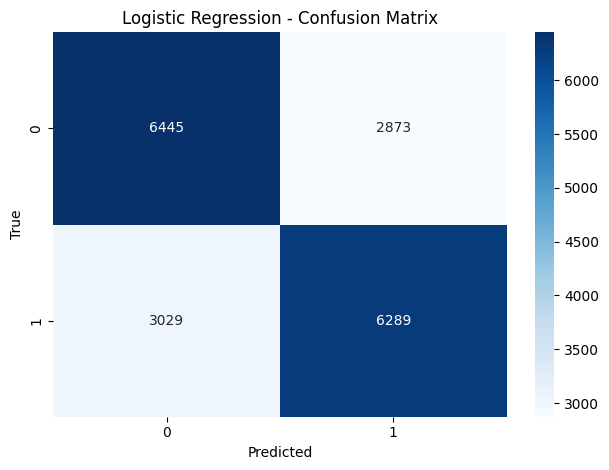


KNN - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.7216, Std = 0.0035
Train Accuracy: 0.8143
Log Loss: 2.2118
ROC AUC: 0.8738
              precision    recall  f1-score   support

           0       0.66      0.97      0.78      9318
           1       0.95      0.49      0.65      9318

    accuracy                           0.73     18636
   macro avg       0.80      0.73      0.72     18636
weighted avg       0.80      0.73      0.72     18636



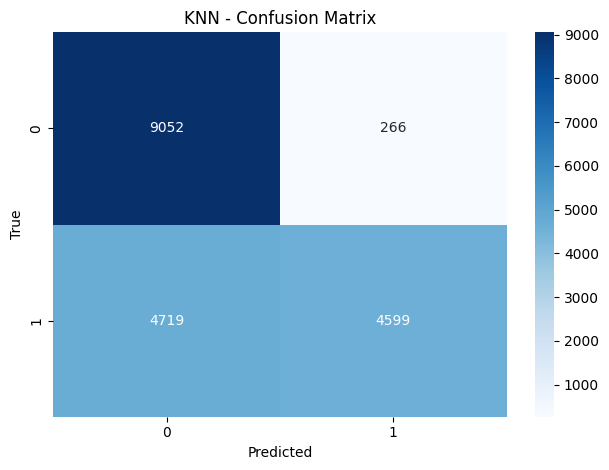


Naive Bayes - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.7010, Std = 0.0030
Train Accuracy: 0.7008
Log Loss: 0.6815
ROC AUC: 0.7609
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      9318
           1       0.72      0.66      0.69      9318

    accuracy                           0.70     18636
   macro avg       0.70      0.70      0.70     18636
weighted avg       0.70      0.70      0.70     18636



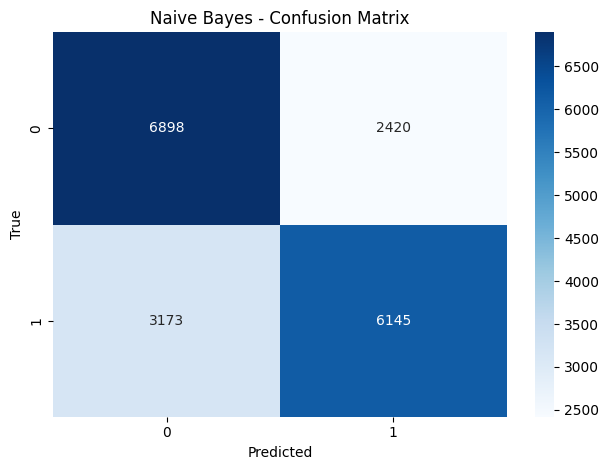


Decision Tree - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.7483, Std = 0.0016
Train Accuracy: 1.0000
Log Loss: 8.8368
ROC AUC: 0.7548
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      9318
           1       0.77      0.73      0.75      9318

    accuracy                           0.75     18636
   macro avg       0.76      0.75      0.75     18636
weighted avg       0.76      0.75      0.75     18636



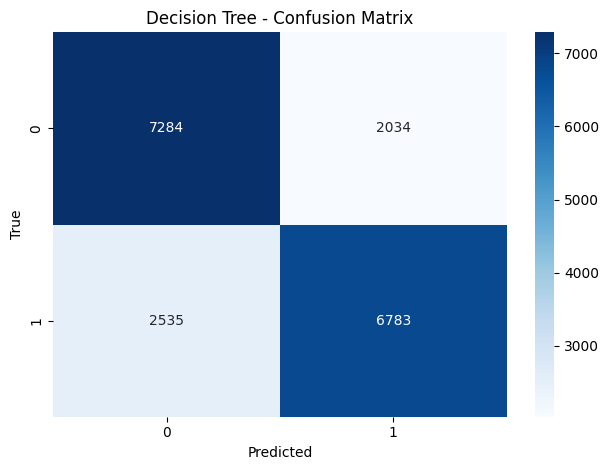


Random Forest - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.8521, Std = 0.0030
Train Accuracy: 1.0000
Log Loss: 0.3958
ROC AUC: 0.9172
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      9318
           1       0.83      0.91      0.87      9318

    accuracy                           0.86     18636
   macro avg       0.86      0.86      0.86     18636
weighted avg       0.86      0.86      0.86     18636



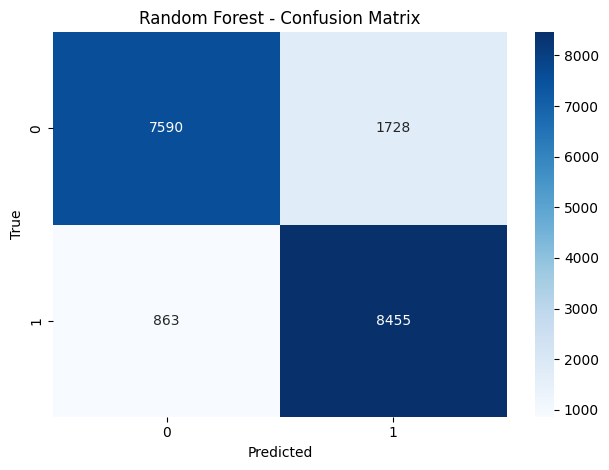

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:09:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:09:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:09:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:09:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:09:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


XGBoost - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.8458, Std = 0.0024
Train Accuracy: 0.8718
Log Loss: 0.3756
ROC AUC: 0.9108
              precision    recall  f1-score   support

           0       0.98      0.71      0.83      9318
           1       0.77      0.99      0.87      9318

    accuracy                           0.85     18636
   macro avg       0.88      0.85      0.85     18636
weighted avg       0.88      0.85      0.85     18636



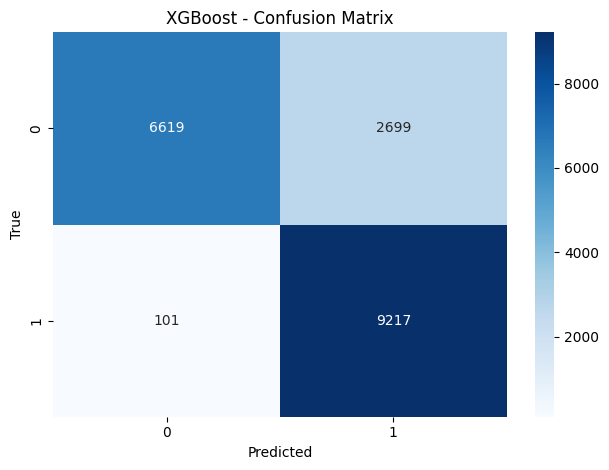


CatBoost - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.8634, Std = 0.0014
Train Accuracy: 0.8935
Log Loss: 0.3394
ROC AUC: 0.9110
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      9318
           1       0.82      0.95      0.88      9318

    accuracy                           0.87     18636
   macro avg       0.88      0.87      0.87     18636
weighted avg       0.88      0.87      0.87     18636



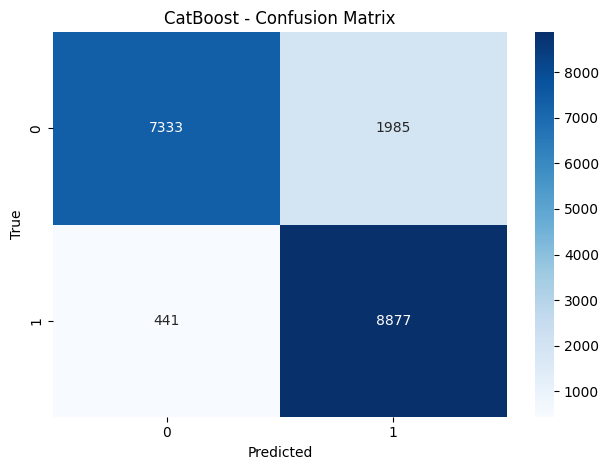


MLP (Neural Network) - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.8037, Std = 0.0067
Train Accuracy: 0.8535
Log Loss: 0.4248
ROC AUC: 0.8806
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      9318
           1       0.79      0.86      0.82      9318

    accuracy                           0.82     18636
   macro avg       0.82      0.82      0.81     18636
weighted avg       0.82      0.82      0.81     18636



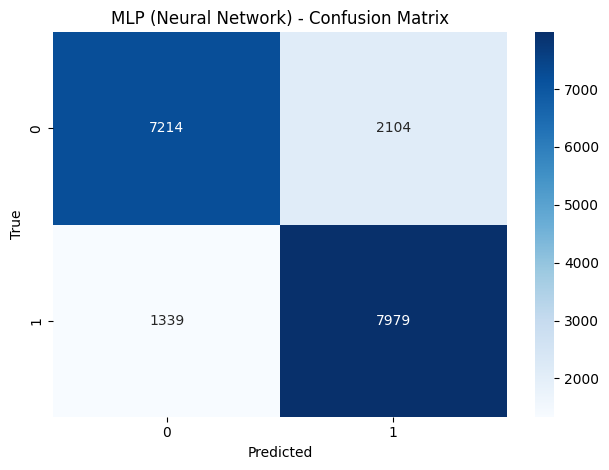


Model Comparison Summary:
                  Model  Mean CV Accuracy  Std CV Accuracy  Train Accuracy  \
6              CatBoost          0.863433         0.001435        0.893550   
5               XGBoost          0.845778         0.002360        0.871844   
4         Random Forest          0.852124         0.003049        1.000000   
7  MLP (Neural Network)          0.803694         0.006692        0.853505   
3         Decision Tree          0.748330         0.001578        1.000000   
2           Naive Bayes          0.701001         0.003001        0.700826   
0   Logistic Regression          0.683306         0.004327        0.684004   
1                   KNN          0.721620         0.003476        0.814252   

   Test Accuracy  Precision    Recall  F1 Score   ROC AUC  Log Loss  
6       0.869822   0.817253  0.952672  0.879782  0.910989  0.339382  
5       0.849753   0.773498  0.989161  0.868136  0.910806  0.375607  
4       0.860968   0.830305  0.907384  0.867135  0.917199  0

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, log_loss
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

# Assuming you have already split the dataset into X_train, X_test, y_train, y_test
# and scaled them as X_train_scaled, X_test_scaled

# Define base models, including MLP (Multilayer Perceptron)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=3),
    "CatBoost": CatBoostClassifier(verbose=0, auto_class_weights='Balanced'),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  # MLP model added
}

# Evaluate models
metrics = []

for name, model in models.items():
    # Perform cross-validation to evaluate the model on the training data
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation

    # Collect metrics for cross-validation
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    # Train the model on the entire training set
    model.fit(X_train_scaled, y_train)

    # Make predictions on the train and test sets
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    y_proba_test = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Collect other metrics
    train_acc = accuracy_score(y_train, y_pred_train)  # Train accuracy
    test_acc = accuracy_score(y_test, y_pred_test)    # Test accuracy
    prec = precision_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else np.nan
    ll = log_loss(y_test, y_proba_test) if y_proba_test is not None else np.nan

    # Print the model report and relevant metrics
    print(f"\n{name} - Cross-Validation Results:")
    print(f"Cross-Validation Accuracy: Mean = {mean_cv_score:.4f}, Std = {std_cv_score:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Log Loss: {ll:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred_test))

    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Collect metrics for the final results
    metrics.append({
        "Model": name,
        "Mean CV Accuracy": mean_cv_score,
        "Std CV Accuracy": std_cv_score,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": auc,
        "Log Loss": ll
    })

# Results DataFrame
results_df = pd.DataFrame(metrics).sort_values(by='F1 Score', ascending=False)
print("\nModel Comparison Summary:")
print(results_df)
